# Lecture 4: Machine Learning for Treatment Effects I

- Feasible IPW Estimator
- Introduction to Supervised Learning.
- Regression vs Classification.
- Linear models. Logistic Regression.
- Tree-based models.

## Feasible IPW Estimator

Along our derivations and analysis of treatment effect estimators using the propensity score $e(X_i)$, we were assuming that the scores were known. In reality however, we won't have access to the true propensity scores. This means that we will have to construct them somehow using the data we have. Using estimated propensity scores $\hat{e}(X_i)$ in IPW leads to the **"feasible" IPW estimator** $\hat{\tau}_{IPW}$ (as opposed to the "oracle" IPW, when we use the true propensities $\hat{\tau}_{IPW^*}$).

It can be shown that, if $\hat{e}(X_i)$ is a consistent estimator of $e(X_i)$, $\hat{\tau}_{IPW}$ will be consistent for $\tau$ as:

$$|\hat{\tau}_{IPW} - \hat{\tau}_{IPW^*}| \overset{p}{\to} 0$$

Therefore, our task is to come up with a consistent set of propensity scores. And here is where Machine Learning excels. 

## Supervised Learning

The language line is blurry, but it is said that we face a **prediction** problem when we try to obtain individual values for a random variable from the available data, as opposed to an **estimation** problem when we try to obtain an estimate of a parameter also from the available data. We estimate treatment effects or variances; we predict propensity scores or outcomes.   

In Machine Learning we deal mostly with prediction problems, where we have a set of inputs or features $X_i$ that we use to guess an output, target or label $Y_i$. Problems like these fall into the category of **Supervised Learning**.

Conceptually, a supervised learning problem is easy to define. We want to predict the value of some target $Y_i$ which is related to our features $X_i$ via some function $f$. We can write this relationship as:

$$Y_i = f(X_i) + \varepsilon_i$$

In other words, we want to come up with an $\hat{f}$ that best approximates $f$.

$Y_i$ can theoretically be anything, like a scalar, a vector, a matrix. It can also be a class among a set of possible classes, or a sequence of elements, for example a sequence of tokens representing our own language 😉.

The last component that defines a supervised learning problem is the **loss function**. A loss function $L(Y, f(X))$ is a function that penalizes the prediction error which we want to minimize.

The choice of the loss function will determine the shape of $\hat{f}$. For example, when $Y_i$ is a scalar, the most common choice of loss is the **mean squared error (MSE)**:

$$MSE = \mathbb{E}[(Y_i - f(X_i))^2]$$

Note that we can condition on $X_i$ to get:

$$MSE = \mathbb{E}\left[\mathbb{E}[(Y_i - f(x))^2]|X=x\right]$$

And we minimize choosing $f$ to obtain:

$$f(x) = \mathbb{E}[Y_i|X_i=x]$$

Which means that the conditional expectation of $Y_i$ given $X_i = x$ gives us the best prediction of $Y_i$, where best is measured by our MSE loss. If, for example, we chose to use the mean absolute error (MAE) as loss function instead, we would see that the $f$ that minimizes MAE is the conditional median.


## Regression vs Classification

Informally, there are two main categories of supervised learning problems depending on what is our target $Y_i$. If $Y_i$ is numeric (for example, a scalar or a vector), we say we are dealing with a **regression** problem. For example, if we are trying to predict household income, cholesterol levels, or the estimated time of a delivery. If $Y_i$ is a class from a well defined set of classes, we say we have a **classification** problem. For example, when we try to determine whether a customer is fraudulent or not, or when we are trying to classify an image as a dog, cat, or bird.

Each type of problem has its own characteristics, but in some cases the line between a regression and a classification problem is algorithmically (but not conceptually) blurry. For example, sometimes we might use a loss function intended for a classification problem to solve a regression problem, or viceversa. In fact, propensity score prediction is one of these blurry cases. We will see why in a moment.

## Linear Models

Let's dive into our main objective: propensity score prediction. We want to predict the propensity scores $e(X_i)$ using $X_i$. We know that $e(X_i) = \mathbb{P}[W_i = 1 |X_i=x] = \mathbb{E}[W_i|X_i=x]$. At first glance, this looks like a simple regression problem where $W_i$ is the target, so why don't we try to solve it by minimizing MSE? We know that we minimize MSE if we set $f$ to the conditional expectation $\mathbb{E}[W_i|X_i=x]$. So we now need to model this conditional expectation function of $x$. Let's start with arguably the simplest specification we can use: a linear model.

$$f(x) = x\beta$$

Let's simulate our observational DGP and see how the linear model does at predicting the propensity score.

\begin{align*}
i &= 1,\ldots, n\\
X_{ij} &\overset{iid}{\sim} \mathcal{U}(-1, 1), \; j \in \{1,2,3\}\\
e(X_i) &= 0.1 + 0.85 * \sqrt{\frac{\text{max}\{0,1+X_{2i}+X_{3i}\}}{3}}\\
W_i &\sim Ber(e(X_i))\\
Y_i &= \text{exp}(X_{1i} + X_{2i}) + \text{max}\{0,X_{3i}\} W_i  
\end{align*}

In [1]:
import dgp_simulation
import estimators
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


def disable_sci(ax):
    ax.ticklabel_format(style="plain", axis="both", useOffset=False)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())

In [2]:
base_params = {
    "p": 0.5,
    "n": 100_000,
    "seed": 42,
    "rct": False,
}

In [3]:
obs_df = dgp_simulation.simulate_dgp(**base_params)
obs_df.head()

,W,Y,X1,X2,X3,prop
0,1,2.247810,0.547912,-0.122243,0.717196,0.719772
1,1,1.610325,0.394736,-0.811645,0.951245,0.623883
2,0,2.987414,0.522279,0.572129,-0.743773,0.546649
3,0,0.699330,-0.099228,-0.258404,0.853530,0.719806
4,0,2.542769,0.287730,0.645523,-0.113172,0.707488


In [4]:
prop_model_linear = LinearRegression().fit(obs_df[['X1','X2','X3']], obs_df['W'])
obs_df['prop_pred_linear'] = prop_model_linear.predict(obs_df[['X1','X2','X3']])

In [5]:
obs_df['prop_pred_linear'].describe()

count    100000.000000
mean          0.543850
std           0.225469
min          -0.007385
25%           0.382406
50%           0.544965
75%           0.705155
max           1.094377
Name: prop_pred_linear, dtype: float64

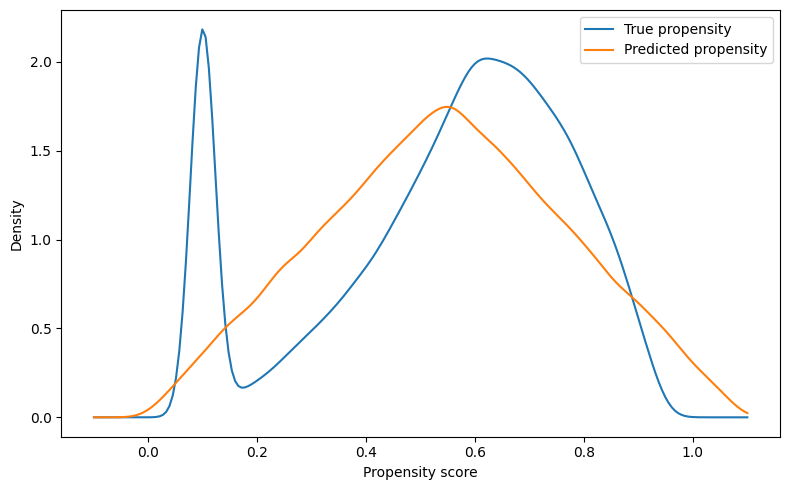

In [6]:
estimators.plot_propensities(obs_df, "prop", "prop_pred_linear")

Something seems off. We are trying to predict a probability, but we are getting values beyond $0$ and $1$, which we know can't be possible. We could always clip the predictions to fall into this range but we want to avoid that kind of discretionary decisions. Let's try that approach to at least compute feasible IPW.

In [7]:
obs_df['prop_pred_linear_clipped'] = obs_df['prop_pred_linear'].clip(0.01,0.99) 

In [8]:
estimators.ipw_estimator(obs_df, propensity_col="prop_pred_linear_clipped")

{'estimate': -0.3277847711315632,
 'std_error': 0.04519691412589645,
 'ci_95': [-0.4163707228183202, -0.23919881944480614],
 'ci_size_perc': 54.05129187725517,
 'p_value': 4.0953945538716654e-13}

This is a well-known limitation of linear models when used to predict probabilities: there is nothing in the specification of the linear model that prevents predictions from falling outside the $[0,1]$ range.

## Logistic Regression

When thinking about the propensity score prediction problem, there is some classification flavor to it: There is a variable $W_i$ that indicates unit $i$ belongs to one of two classes, treatment or control. We are not really interested in predicting which class each units belongs to (treatment status is actually observable), but perhaps we can borrow some of the methods used to handle classification problems.

Logistic regression starts from assuming that the log-odds of the target variable are a linear function of the features.

$$\text{log}\left(\frac{\mathbb{P}[W_i = 1 |X_i=x]}{\mathbb{P}[W_i = 0 |X_i=x]}\right) = x\beta$$

 Incorporating the fact that the probabilities must sum to $1$, the model becomes completely specified and it is straight-forward to see that:

\begin{align*}
\mathbb{P}[W_i = 1 |X_i=x] &= \frac{\text{exp}(x\beta)}{1+\text{exp}(x\beta)}\\
\mathbb{P}[W_i = 0 |X_i=x] &= \frac{1}{1+\text{exp}(x\beta)}\\
\end{align*}

Note that we arbitrarily chose $W_i = 0$ to be the "base class", and the log-odds will be defined with respect to this class, but results are actually invariant to which class we choose as "base".

How do we fit this model? Because we have the specification for each of the probabilities of this discrete group of classes, we have a completely specified multinomial distribution. Thus, it is very reasonable that we attempt a maximum likelihood approach. The likelihood function for this problem is (we still assume $iid$ observations):

\begin{align*}
\mathcal{L}(\beta) &\propto \prod_i \prod_k \mathbb{P}[W_i = k |X_i=x_i]^{\mathcal{I}\{W_i = k\}}\\
\end{align*}

with $k \in \{0,1\}$ for all $i$. We can take logs and obtain a simpler log-likelihood function by operating algebraically and using our model specification:

\begin{align*}
\mathcal{l}(\beta) &= \sum_i \sum_k \text{log}\left(\mathbb{P}[W_i = k |X_i=x_i]^{\mathcal{I}\{W_i = k\}}\right)\\
\mathcal{l}(\beta) &= \sum_i \sum_k \left\{ {\mathcal{I}\{W_i = k\}}\text{log}\left(\mathbb{P}[W_i = k |X_i=x_i]\right)\right\}\\
\mathcal{l}(\beta) &= \sum_i \left\{W_i\text{ log}\left(\mathbb{P}[W_i = 1 |X_i=x_i]\right) + (1-W_i)\text{ log}\left(\mathbb{P}[W_i = 0 |X_i=x_i]\right)\right\}\\
\mathcal{l}(\beta) &= \sum_i \left\{W_i\text{ log}\left(\frac{\text{exp}(x_i\beta)}{1+\text{exp}(x_i\beta)}\right) + (1-W_i)\text{ log}\left(\frac{1}{1+\text{exp}(x_i\beta)}\right)\right\}\\
\mathcal{l}(\beta) &= \sum_i \left\{W_i x_i\beta - \text{log}\left(1+ \text{exp}(x_i\beta)\right)\right\}\\
\end{align*}

One can then take derivatives to obtain the set score equations and solve the system using some numerical method, as its solution does not typically have a closed form.

Let's fit a Logistic model and observe what predictions look like.

In [9]:
prop_model_logistic = LogisticRegression().fit(obs_df[['X1','X2','X3']], obs_df['W'])
obs_df['prop_pred_logistic'] = prop_model_logistic.predict_proba(obs_df[['X1','X2','X3']])[:,1]

In [10]:
obs_df['prop_pred_logistic'].describe()

count    100000.000000
mean          0.543860
std           0.226816
min           0.077364
25%           0.361506
50%           0.556552
75%           0.733345
max           0.948687
Name: prop_pred_logistic, dtype: float64

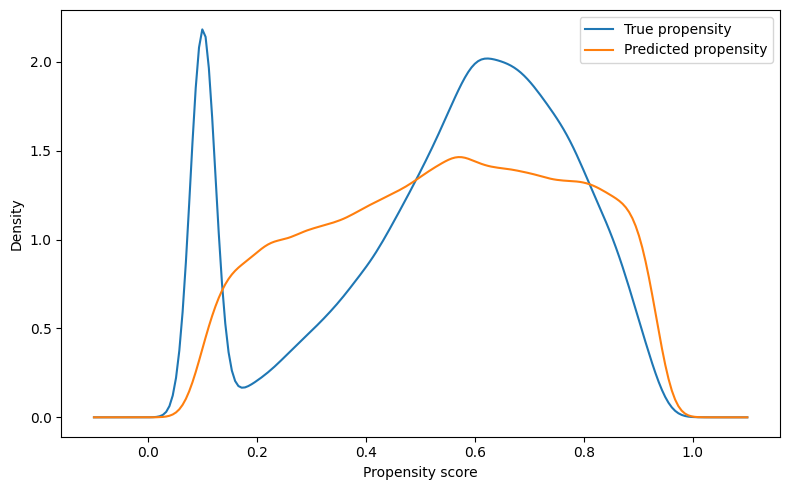

In [11]:
estimators.plot_propensities(obs_df, "prop", "prop_pred_logistic")

In [12]:
estimators.ipw_estimator(obs_df, propensity_col="prop_pred_logistic")

{'estimate': 0.1772176345647464,
 'std_error': 0.015768768535805285,
 'ci_95': [0.14631084823456805, 0.20812442089492475],
 'ci_size_perc': 34.88003482958866,
 'p_value': 2.6376457562104117e-29}

Looks better but it is still very far off. How about the stratified estimator?

In [13]:
estimators.stratified_estimator(obs_df, cov="prop_pred_logistic", cutoffs=np.linspace(0, 1, 11).tolist())

{'estimate': 0.2703634593332643,
 'strata_df':     bin_low  bin_high  estimate   weight  count
 0      -inf       0.0       NaN  0.00000      0
 1       0.0       0.1 -0.006699  0.00544    544
 2       0.1       0.2  0.007666  0.07693   7693
 3       0.2       0.3  0.046612  0.10084  10084
 4       0.3       0.4  0.058734  0.11132  11132
 5       0.4       0.5  0.150620  0.12622  12622
 6       0.5       0.6  0.265384  0.14353  14353
 7       0.6       0.7  0.314231  0.14002  14002
 8       0.7       0.8  0.384487  0.13461  13461
 9       0.8       0.9  0.586684  0.12516  12516
 10      0.9       1.0  0.898579  0.03593   3593
 11      1.0       inf       NaN  0.00000      0}

Much closer. It seems that the stratified estimator gets around the gap between the predicted and real propensities better. Will this work with the linear propensity model as well?

In [14]:
estimators.stratified_estimator(obs_df, cov="prop_pred_linear", cutoffs=np.linspace(0, 1, 11).tolist())

{'estimate': 0.2679703903403784,
 'strata_df':     bin_low  bin_high  estimate   weight  count
 0      -inf       0.0       NaN  0.00014     14
 1       0.0       0.1 -0.005870  0.01923   1923
 2       0.1       0.2  0.029734  0.05205   5205
 3       0.2       0.3  0.010730  0.08485   8485
 4       0.3       0.4  0.060208  0.11639  11639
 5       0.4       0.5  0.138405  0.15033  15033
 6       0.5       0.6  0.292708  0.17215  17215
 7       0.6       0.7  0.305622  0.14833  14833
 8       0.7       0.8  0.394432  0.11390  11390
 9       0.8       0.9  0.527916  0.07979   7979
 10      0.9       1.0  0.849766  0.04772   4772
 11      1.0       inf  0.955803  0.01512   1512}

Why is the case that the stratified estimator works better? Let's look at how we are creating the propensity score as a function of $X_i$:

$$e(X_i) = 0.1 + 0.85 * \sqrt{\frac{\text{max}\{0,1+X_{2i}+X_{3i}\}}{3}}$$

It is clear that the propensity score is not well specified neither with the linear nor logistic models. However, despite being non-linear, the relationship between the propensities and the covariates is simple enough that the two models have a very good chance of approximating it, at least directionally:      

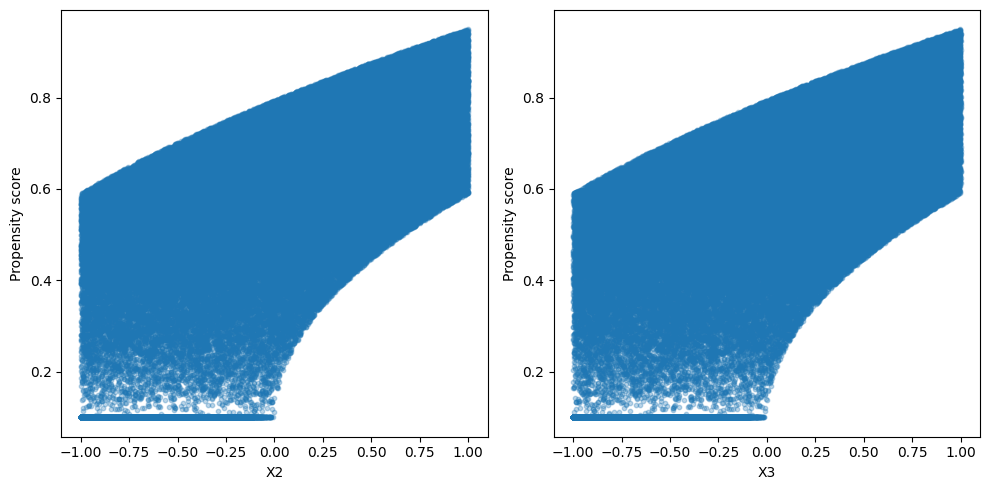

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(obs_df["X2"], obs_df["prop"], alpha=0.3, s=10)
axes[0].set_ylabel("Propensity score")
axes[0].set_xlabel("X2")

axes[1].scatter(obs_df["X3"], obs_df["prop"], alpha=0.3, s=10)
axes[1].set_ylabel("Propensity score")
axes[1].set_xlabel("X3")

plt.tight_layout()
plt.show()

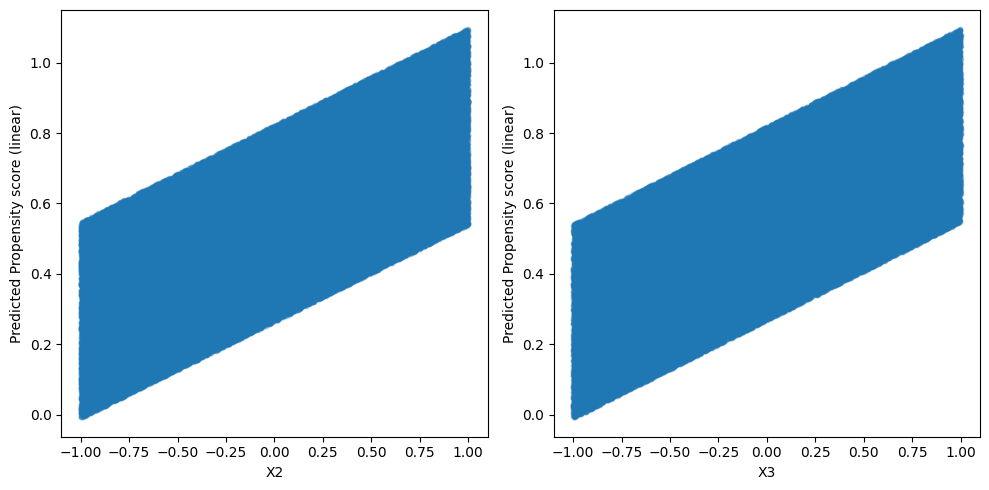

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(obs_df["X2"], obs_df["prop_pred_linear"], alpha=0.3, s=10)
axes[0].set_ylabel("Predicted Propensity score (linear)")
axes[0].set_xlabel("X2")

axes[1].scatter(obs_df["X3"], obs_df["prop_pred_linear"], alpha=0.3, s=10)
axes[1].set_ylabel("Predicted Propensity score (linear)")
axes[1].set_xlabel("X3")

plt.tight_layout()
plt.show()

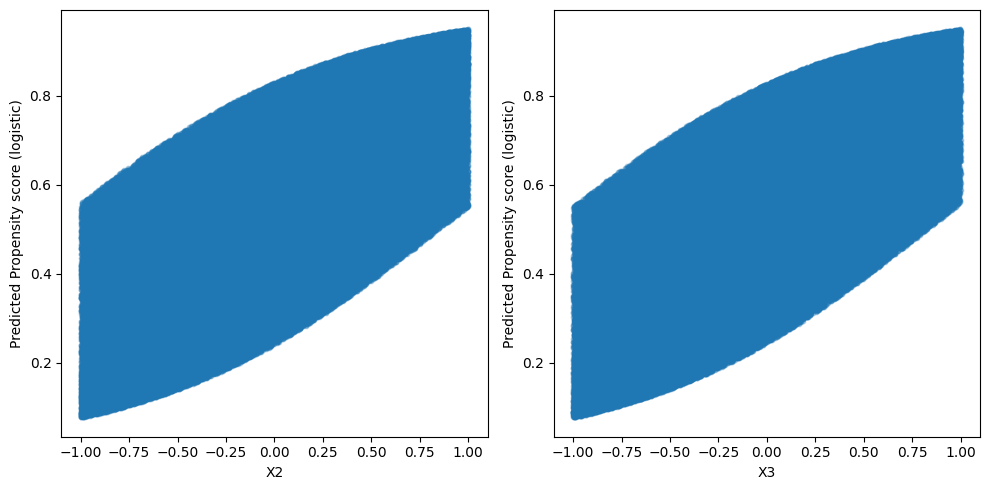

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(obs_df["X2"], obs_df["prop_pred_logistic"], alpha=0.3, s=10)
axes[0].set_ylabel("Predicted Propensity score (logistic)")
axes[0].set_xlabel("X2")

axes[1].scatter(obs_df["X3"], obs_df["prop_pred_logistic"], alpha=0.3, s=10)
axes[1].set_ylabel("Predicted Propensity score (logistic)")
axes[1].set_xlabel("X3")

plt.tight_layout()
plt.show()

The stratified estimator is more robust to discrepancies between the predicted and actual propensity score and much more robust to extreme values of the propensity score. Hence, with a model that works at least directionally, it makes sense that it estimates the treatment effect reasonably well. Because our predicted propensity scores are not consistent, feasible IPW will drastically fail.

## Tree-based Models

Linearity limitations can be sorted through a number of approaches. For example, we could add interaction terms to our linear specification, but the model can become saturated pretty quickly. An alternative algorithm that helps overcoming this limitation is the **decision tree**. Decision trees are conceptually very simple, but they are also really powerful as they can fit non-linear relationships extremely well. Therefore, tree-based models became extremely prominent in Machine Learning applications.

A decision tree is constructed by partitioning the feature space $\mathcal{X}$ into regions $R_1, \ldots, R_M$. We will assign a predicted value to the units belonging to that region through a region-specific function $f_m(X_i)$. As always, we want to minimize the predicted error, so we want that predicted value to be as accurate as possible. There are two components of the algorithm that we need to specify. First, how we define the regions. Second, our choice of $f_m(X_i)$ for each of the $M$ regions.

Let's start with the latter, as it is a special case of the type of problems that we faced before. Our choice of $f_m(X_i)$ will depend on the loss function we want to minimize. For example, if we want to use MSE as our loss function, $f_m(X_i)$ should be the conditional expectation. This is usually the case for regression trees, and we typically set $\hat{f}_m(X_i)$ to a constant (the constant that minimizes MSE in this case is the sample mean from the observations belonging to that region).

Now, how do we define the regions? For continuous, high-dimensional $\mathcal{X}$, it is obviously infeasible to compute all the possible partitions, compute the MSE (or whatever loss we want to use), and choose the partition that minimizes the global MSE. The standard approach is to do it sequentially, using a "greedy" algorithm. We start at the "root" of the tree, and "evaluate" all possible binary splits across our covariates and their values. "Evaluate" here means estimating the total MSE (adding it up region by region) and choosing the split that minimizes it. After we find the split, we assign units to each of the regions depending on whether they fall to one side of the split or the other. For example, if the split is set at $X_{1i} \geq 0$, all units with $x_i \geq 0$ will belong to one region, and all units with $x_i < 0$ will belong to the other region. Then, we repeat the process sequentially treating as root each of the regions. We continue doing this until the next split of the feature space does not reduce the total MSE.  

Note the "greedy" fashion of the algorithm: when defining a split we only care about how the MSE changes on that step, without looking ahead on how the split conditions potential subsequent splits.

Classification trees work similarly, and we have a number of options for loss functions that are common. Within each region, we choose among the two classes, $0$ or $1$ that minimizes the loss of our choice. Letting $\hat{p} = \frac{1}{n_m}\sum_{x_i \in R_m} \mathcal{I}\{y_i = 1\}$ be the proportion of observations belonging to class $1$, a common choice for loss function is naturally the (negative) log-likelihood we derived above:

$$L(y_i,f_m(X_i)) = -\left[p\text{ log}(p)+(1-p)\text{ log}(1-p)\right]$$

But there are others that penalize the "impurity" of the regions more harshly, for example the misclassification error:

$$L(y_i,f_m(X_i)) = 1-\text{max}\{p, 1-p\}$$

or Gini index:

$$L(y_i,f_m(X_i)) = p(1-p)$$

Because our propensity scores problem is a bit of a hybrid case, let's try both a regression and classification tree and study the differences.

In [18]:
prop_model_reg_tree = DecisionTreeRegressor().fit(obs_df[["X1", "X2", "X3"]], obs_df["W"])
obs_df["prop_pred_reg_tree"] = prop_model_reg_tree.predict(obs_df[["X1", "X2", "X3"]])

In [19]:
obs_df['prop_pred_reg_tree'].describe()

count    100000.000000
mean          0.543850
std           0.498076
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: prop_pred_reg_tree, dtype: float64

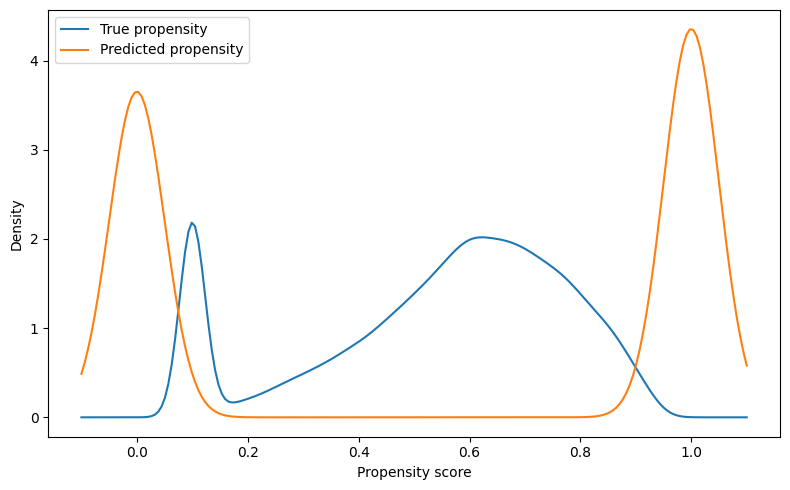

In [20]:
estimators.plot_propensities(obs_df, "prop", "prop_pred_reg_tree")

Interesting! The tree is predicting only two values for the propensities: 0 and 1. Why could this be happening?

Let's try fitting a tree limiting its depth.

In [21]:
prop_model_reg_tree = DecisionTreeRegressor(max_depth=3).fit(obs_df[["X1", "X2", "X3"]], obs_df["W"])
obs_df["prop_pred_reg_tree"] = prop_model_reg_tree.predict(obs_df[["X1", "X2", "X3"]])

In [22]:
obs_df['prop_pred_reg_tree'].describe()

count    100000.000000
mean          0.543850
std           0.215907
min           0.144995
25%           0.464465
50%           0.619129
75%           0.712989
max           0.817905
Name: prop_pred_reg_tree, dtype: float64

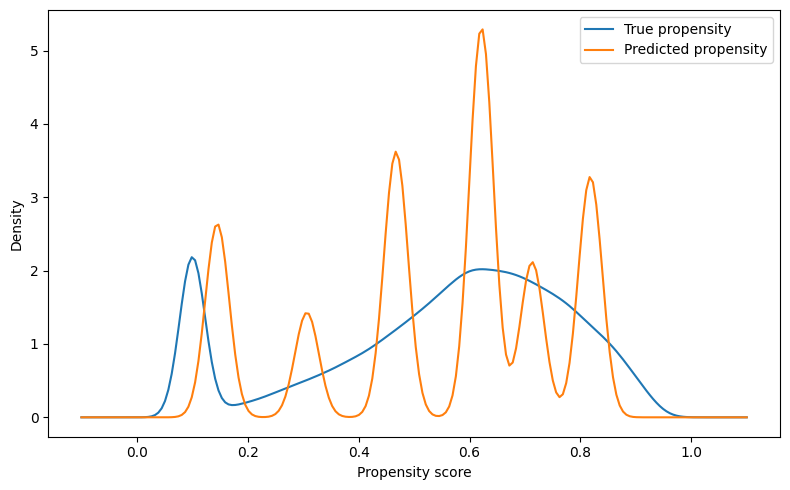

In [23]:
estimators.plot_propensities(obs_df, "prop", "prop_pred_reg_tree")

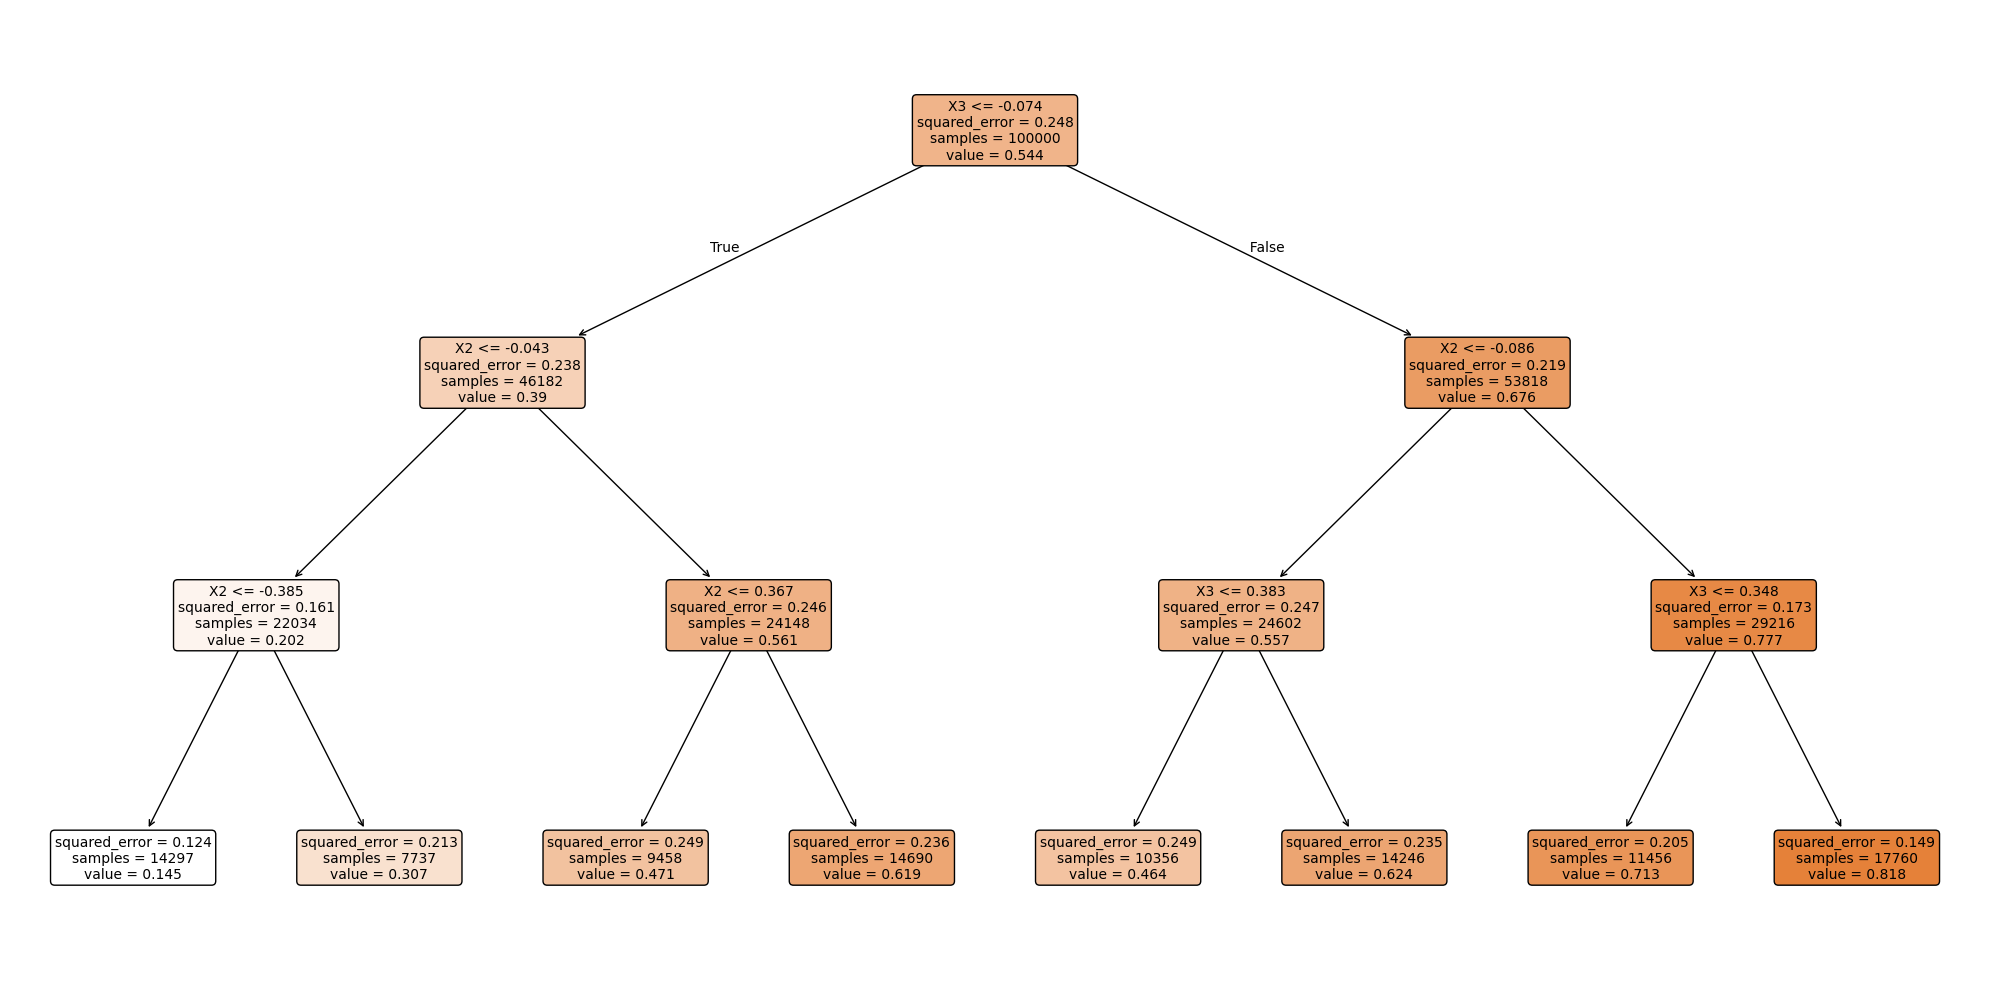

In [24]:
plt.figure(figsize=(20, 10))
plot_tree(prop_model_reg_tree, feature_names=["X1", "X2", "X3"], filled=True, rounded=True, fontsize=10)
plt.tight_layout()
plt.show()

In [25]:
estimators.ipw_estimator(obs_df, propensity_col="prop_pred_reg_tree")

{'estimate': 0.3511749831919999,
 'std_error': 0.013037108494360747,
 'ci_95': [0.3256222505430528, 0.376727715840947],
 'ci_size_perc': 14.552706697205986,
 'p_value': 8.195362115946258e-160}

Let's try increasing the max depth.

In [26]:
prop_model_class_tree = DecisionTreeClassifier(criterion='log_loss',max_depth=5).fit(obs_df[["X1", "X2", "X3"]], obs_df["W"])
obs_df["prop_pred_class_tree"] = prop_model_class_tree.predict_proba(obs_df[["X1", "X2", "X3"]])[:,1]

In [27]:
obs_df['prop_pred_class_tree'].describe()

count    100000.000000
mean          0.543850
std           0.229880
min           0.100858
25%           0.419737
50%           0.600000
75%           0.720679
max           0.916088
Name: prop_pred_class_tree, dtype: float64

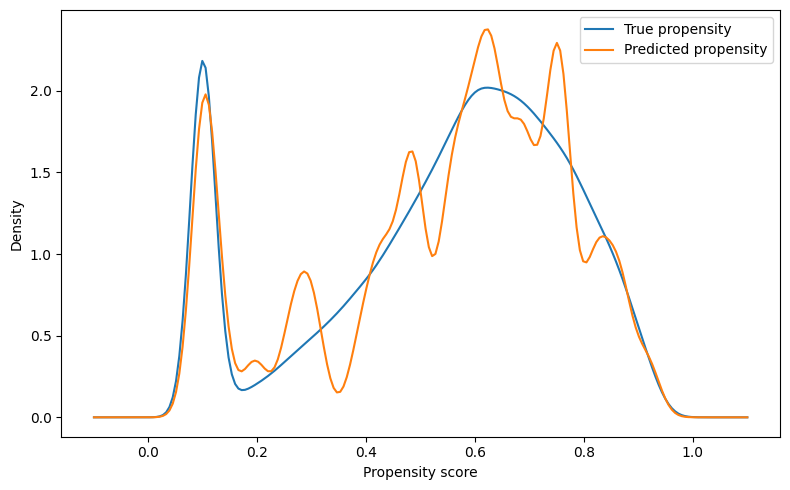

In [28]:
estimators.plot_propensities(obs_df, "prop", "prop_pred_class_tree")

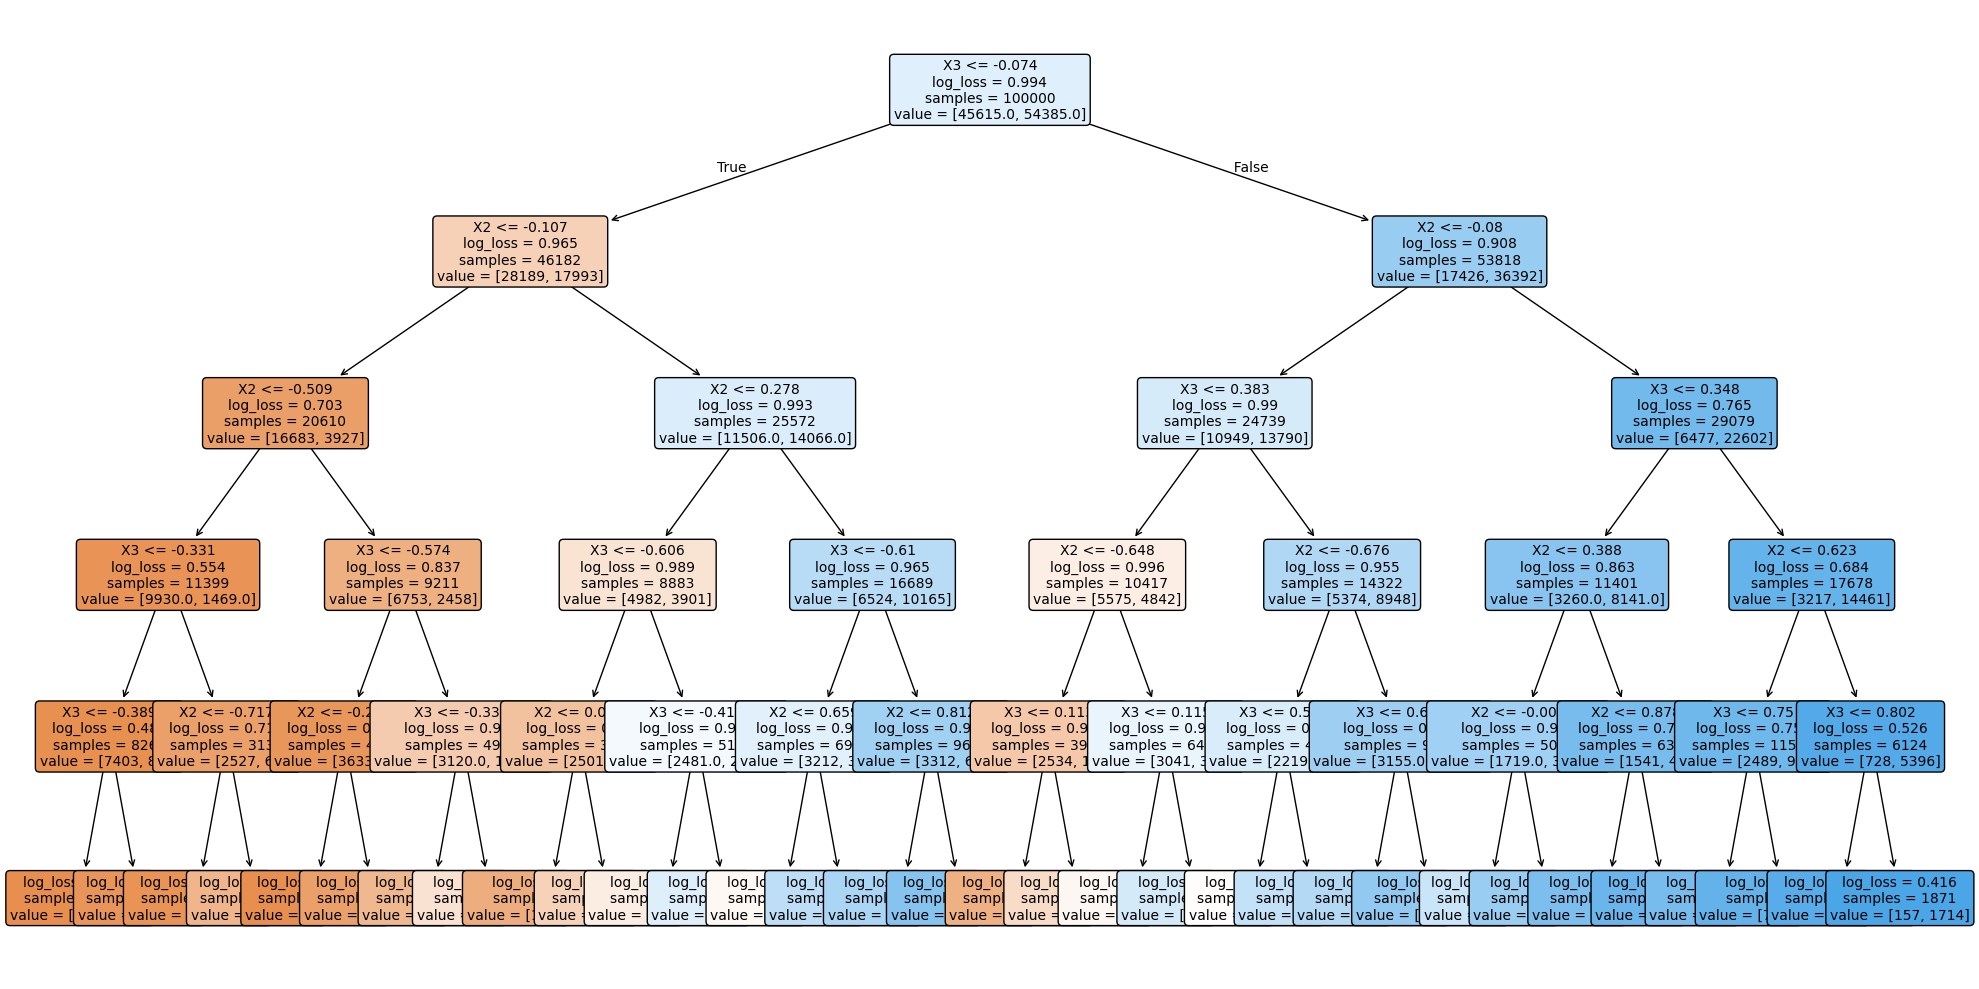

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(prop_model_class_tree, feature_names=["X1", "X2", "X3"], filled=True, rounded=True, fontsize=10)
plt.tight_layout()
plt.show()

In [30]:
estimators.ipw_estimator(obs_df, propensity_col="prop_pred_class_tree")

{'estimate': 0.27604301880744575,
 'std_error': 0.014181312471910942,
 'ci_95': [0.2482476463625003, 0.3038383912523912],
 'ci_size_perc': 20.138435353320173,
 'p_value': 2.163686504200932e-84}